# MSIS Examples

This notebook is designed to give a quick interactive overview of the MSIS model and how adjusting the input parameters affects the upper atmosphere. We will go through a few quick examples and demonstrations, before the homework problems towards the end of the notebook.

If you prefer a web interface to coding, there is also an interactive website here: https://msis.swx-trec.com/visualizer
that you can follow along with and download all of the necessary data for the homework problems.

### NRL Mass Spectrometer, Incoherent Scatter Radar Extended Model (MSIS)

The MSIS model is developed by the Naval Research Laboratory.

Note that the MSIS2 code is not available for commercial use without contacting NRL. See the MSIS2 license file for explicit details. We do not repackage any of the MSIS source code in this repository for that reason. However, we do provide utilities to easily download and extract the original source code. By using that code you agree to their terms and conditions.

MSIS2.0
> Emmert, J. T., Drob, D. P., Picone, J. M., Siskind, D. E., Jones, M., Mlynczak, M. G., et al. (2020). NRLMSIS 2.0: A whole‐atmosphere empirical model of temperature and neutral species densities. Earth and Space Science, 7, e2020EA001321. 10.1029/2002JA009430

MSISE-00
> Picone, J. M., Hedin, A. E., Drob, D. P., and Aikin, A. C., NRLMSISE‐00 empirical model of the atmosphere: Statistical comparisons and scientific issues, J. Geophys. Res., 107( A12), 1468, doi:10.1029/2002JA009430, 2002.



In [1]:
%matplotlib widget
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymsis import msis

## Diurnal variations

https://swxtrec.github.io/pymsis/examples/plot_diurnal_variation.html

In [2]:
import matplotlib.dates as mdates

class DiurnalVariations:
    def __init__(self):
        self.lon = 0
        self.lat = 0
        self.alt = 200
        self.F107 = 150
        self.F107a = 150
        self.Ap = 7
        # One days worth of data every minute
        self.dates = np.arange('2003-01-01', '2003-01-02', dtype='datetime64[m]')
        # Every minute for a day and 11 variables
        self.data = np.zeros((len(self.dates), 11))

        # Set up the figure
        self._variables = ['Total mass density', 'N2', 'O2', 'O', 'He',
                     'H', 'Ar', 'N', 'Anomalous O', 'NO', 'Temperature']
        self.fig, self.ax = plt.subplots(figsize=(8, 5))
        ax = self.ax
        # Loop over all variables and make the lines
        self.lines = {name: None for name in self._variables}
        for i, label in enumerate(self._variables):
            self.lines[label], = ax.plot(self.dates, self.data[:, i], label=label)
            if label == 'NO':
                # There is currently no NO data, so hide the line
                self.lines[label].set_visible(False)
        
        # Add labels
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=True, ncol=1)
        ax.set_xlabel('Time of day (UTC)')
        ax.set_ylabel('Difference from the daily mean (%)')
        ax.set_xlim(self.dates[0], self.dates[-1])
        ax.set_ylim(-150, 150)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        # Update the values before showing, which runs the parameters
        self.update()
        self.fig.tight_layout()
        plt.show()
        
    def update(self):
        ndates = len(self.dates)
        # (F107, F107a, ap) all need to be specified at the same length as dates
        f107s = [self.F107]*ndates
        f107as = [self.F107a]*ndates
        aps = [[self.Ap]*7]*ndates

        # The actual computations
        output = msis.run(self.dates, self.lon, self.lat, self.alt, f107s, f107as, aps)
        #  output is now of the shape (ndates, 1, 1, 1, 11)
        # Get rid of the single dimensions
        output = np.squeeze(output)

        # Lets get the percent variation from the daily mean for each variable
        self.data = 100*(output/output.mean(axis=0) - 1)
        # Iterate and update all of the lines of our plot
        for i, label in enumerate(self._variables):
            self.lines[label].set_ydata(self.data[:, i])


<IPython.core.display.Javascript object>


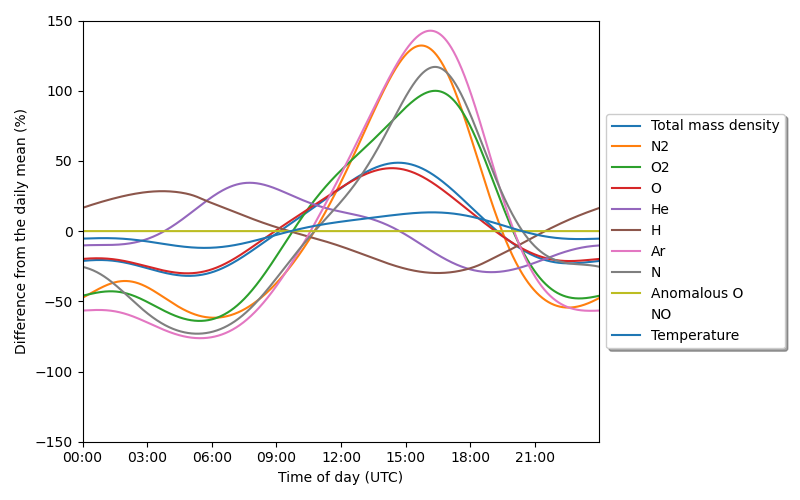

interactive(children=(IntSlider(value=0, description='lat', max=90, min=-90), IntSlider(value=0, description='…

In [3]:
diurnal_plot = DiurnalVariations()

@interact(lon=(-180, 180), lat=(-90, 90), alt=(0, 1000), F107=(50, 300), F107a=(50, 300), Ap=(0, 300))
def _update_vals(lat, lon, alt, F107, F107a, Ap):
    diurnal_plot.lat = lat
    diurnal_plot.lon = lon
    diurnal_plot.alt = alt
    diurnal_plot.F107 = F107
    diurnal_plot.F107a = F107a
    diurnal_plot.Ap = Ap
    # Run/update the model after setting all the variables
    diurnal_plot.update()


## Altitude Profiles

https://swxtrec.github.io/pymsis/examples/plot_altitude_profiles.html

In [4]:
class AltitudeProfiles:
    def __init__(self):
        self.lon = 0
        self.lat = 0
        self.alts = np.arange(1001)
        self.F107 = 150
        self.F107a = 150
        self.Ap = 7
        self.date = np.datetime64('2003-01-01T00:00')
        # Hour of day
        self.hour = 0
        # Every minute for a day and 11 variables
        self.data = np.ones((len(self.alts), 11))

        # Set up the figure
        self._variables = ['Total mass density', 'N2', 'O2', 'O', 'He',
                     'H', 'Ar', 'N', 'Anomalous O', 'NO', 'Temperature']
        self.fig, self.ax = plt.subplots(figsize=(8, 5))

        ax = self.ax
        # Loop over all variables and make the lines
        self.lines = {name: None for name in self._variables}
        for i, label in enumerate(self._variables):
            self.lines[label], = ax.plot(self.data[:, i], self.alts, label=label)
            if label == 'NO':
                # There is currently no NO data, so hide the line
                self.lines[label].set_visible(False)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=True, ncol=1)
        ax.set_xscale('log')
        ax.set_xlim(1e8, 1e18)
        ax.set_ylim(0, 1000)
        ax.set_xlabel('Number density (/m$^3$)')
        ax.set_ylabel('Altitude (km)')
        
        # Update the values before showing, which runs the parameters
        self.update()
        self.fig.tight_layout()
        plt.show()
        
    def update(self):
        aps = [[self.Ap]*7]
        time = self.date + np.timedelta64(self.hour, "h")

        # The actual computations
        output = msis.run(time, self.lon, self.lat, self.alts, self.F107, self.F107a, aps)
        #  output is now of the shape (1, 1, 1, 1001, 11)
        # Get rid of the single dimensions
        self.data = np.squeeze(output)

        # Iterate and update all of the lines of our plot
        for i, label in enumerate(self._variables):
            self.lines[label].set_xdata(self.data[:, i])
        

<IPython.core.display.Javascript object>


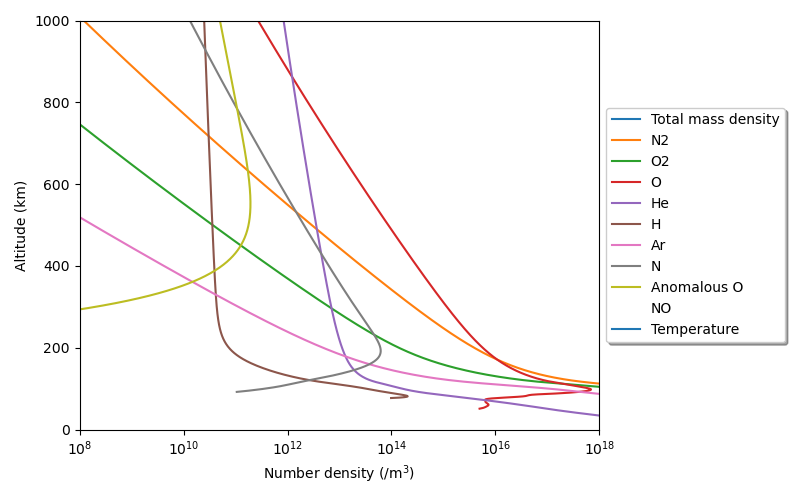

interactive(children=(IntSlider(value=0, description='lat', max=90, min=-90), IntSlider(value=0, description='…

In [5]:
altitude_plot = AltitudeProfiles()

@interact(lon=(-180, 180), lat=(-90, 90), hour=(0, 24), F107=(50, 300), F107a=(50, 300), Ap=(0, 300))
def _update_vals(lat, lon, hour, F107, F107a, Ap):
    altitude_plot.lat = lat
    altitude_plot.lon = lon
    altitude_plot.hour = hour
    altitude_plot.F107 = F107
    altitude_plot.F107a = F107a
    altitude_plot.Ap = Ap
    # Run/update the model after setting all the variables
    altitude_plot.update()


## Surface plot

https://swxtrec.github.io/pymsis/examples/plot_surface.html

In [6]:
class SurfacePlot:
    def __init__(self):
        """Set up a figure with a surface and altitude plot."""
        # Grids for the altitude and surface plots
        self.alt = 200
        self.lons = np.arange(-180, 185, 5)
        self.lats = np.arange(-90, 95, 5)
        self.F107 = 150
        self.F107a = 150
        self.Ap = 7
        self.date = np.datetime64('2003-01-01T00:00')
        # Hour of day
        self.hour = 0
        # lon, lat, variables
        self.data = np.ones((len(self.lons), len(self.lats), 11))
        # Set up the figure
        self.variable = "Total mass density"
        self._variables = ['Total mass density', 'N2', 'O2', 'O', 'He',
                     'H', 'Ar', 'N', 'Anomalous O', 'NO', 'Temperature']
        self._variable_lookup = {name: i for i, name in enumerate(self._variables)}

        self.fig, self.ax = plt.subplots(figsize=(8, 5))

        ax = self.ax
        # Surface image
        self.image = ax.imshow(self.data[:, :, 0].T, extent=(-180, 180, -90, 90))
        plt.colorbar(self.image, ax=self.ax, orientation="horizontal")
        # Sun circle
        self.sun, = ax.plot(0, 0, marker='o', markersize=10, markerfacecolor="gold", markeredgecolor="k")
        
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Update the values before showing, which runs the parameters
        self.update()
        self.fig.tight_layout()
        plt.show()
        
    def update(self):
        """Update the model accounting for any changes that have been made"""
        i = self._variable_lookup[self.variable]
        # Surface
        time = self.date + np.timedelta64(self.hour, "h")
        out = msis.run(time, self.lons, self.lats, self.alt,
                       self.F107, self.F107a, [[self.Ap]*7])
        # Use the ith index which is our variable of interest
        surf_data = np.squeeze(out)[:, :, i].T
        self.image.set_array(surf_data)
        self.image.norm.vmin = np.min(surf_data)
        self.image.norm.vmax = np.max(surf_data)
        
        # This is the correct latitude if we account for the month/day of year too
        # Update the solar position to the current date
        date = pd.Timestamp(time)
        # declination of the sun
        lat = -23.44 * np.cos(360/365*(date.dayofyear + 10))
        # longitude of the sun
        lon = -15*(date.hour + date.minute/60 + date.second/3600 - 12)
        self.sun.set_data(lon, lat)


<IPython.core.display.Javascript object>


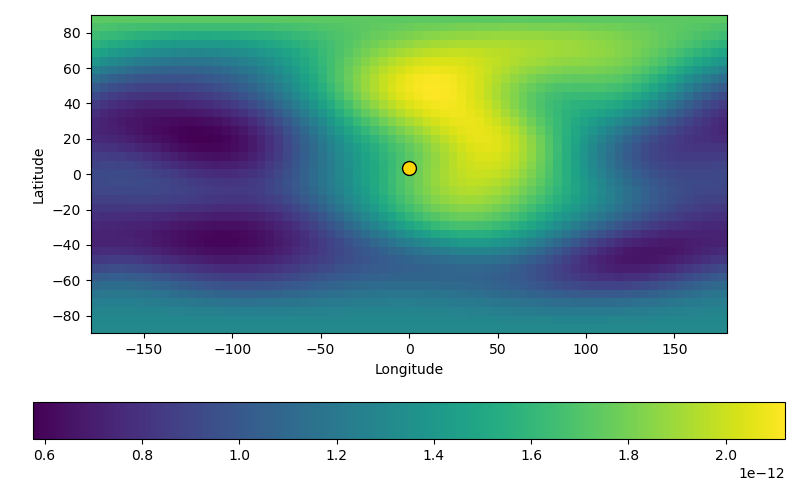

interactive(children=(Dropdown(description='variable', options=('Total mass density', 'N2', 'O2', 'O', 'He', '…

In [7]:
surface_plot = SurfacePlot()

@interact(variable=surface_plot._variables, alt=(0, 1000), hour=(0, 24), F107=(50, 300), F107a=(50, 300), Ap=(0, 300))
def _update_vals(variable, alt, hour, F107, F107a, Ap):
    surface_plot.variable = variable
    surface_plot.alt = alt
    surface_plot.hour = hour
    surface_plot.F107 = F107
    surface_plot.F107a = F107a
    surface_plot.Ap = Ap
    # Run/update the model after setting all the variables
    surface_plot.update()


## Questions

Use the NRLMSISE-00 neutral atmosphere empirical model to evaluate altitude profiles of thermosphere parameters. In applying MSIS use the following set of input parameters:

```
year= 2000, month= 01, day= 01, hour=0.,
Time_type = Universal
Coordinate_type = Geographic
latitude= 40, longitude= 105, height= 100.
profile parameters: start= 100. stop= 1000. step= 10.
```

Run MSIS for both solar min and max conditions:

* Solar max parameters: F10.7(daily) =200.; F10.7a(3-month avg) =200.
* Solar min parameters: F10.7(daily) =80.; F10.7a(3-month avg) =80.; ap(daily) = 4.

All of the following calculations involve plots in altitude versus a property from 100-1000 km for both solar maximum and solar minimum using output from the MSIS model:

a) Compute the altitude profile of mean molecular weight and pressure scale height of the thermosphere.

b) Assuming hard-sphere, neutral-neutral interactions, compute a weighted-mean, momentum transfer collision frequency, vst, profile with altitude for helium as the “s” species interacting with three major “t” species, N2, O2, and O.

c) Compute altitude profiles of the helium diffusion coefficient using equation (10.53) and the weighted-mean collision frequency from part b.

d) Compute altitude profiles of the helium viscosity coefficient and thermal conductivity from problem 1, part c.

In [8]:
date = np.datetime64("2000-01-01T00:00")
altitudes = np.arange(100, 1001, 10)
latitude = 40
longitude = 105
variables = ['Total mass density', 'N2', 'O2', 'O', 'He',
             'H', 'Ar', 'N', 'Anomalous O', 'NO', 'Temperature']
variable_lookup = {name: i for i, name in enumerate(variables)}

<IPython.core.display.Javascript object>


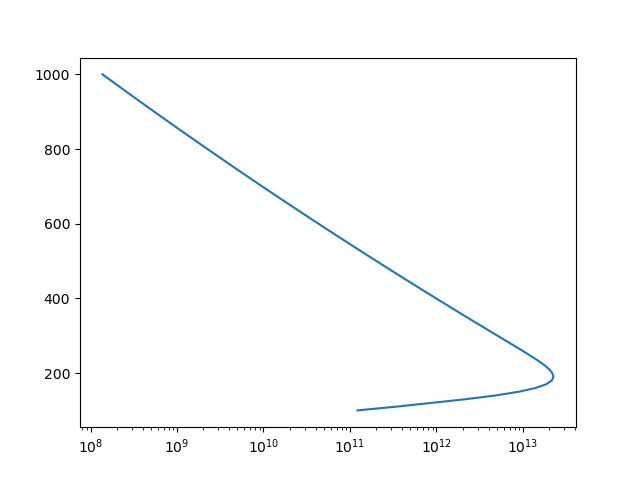

In [9]:
### MODIFY THE VALUES BELOW WHEN UPDATING FOR YOUR HOMEWORK!

# Solar max
F107 = 200
F107a = 200
ap = 4

output = np.squeeze(msis.run(date, longitude, latitude, altitudes, F107, F107a, [[ap]*7]))
# Get the altitude profile for the Nitrogen variable out of the array.
nitrogen_data = output[:, variable_lookup["N"]]

### Plot of your quantities

fig, ax = plt.subplots()

ax.semilogx(nitrogen_data, altitudes)

### a) Compute the altitude profile of mean molecular weight and pressure scale height of the thermosphere.

In [10]:
# Expand upon the examples above, putting your code here


### b) Assuming hard-sphere, neutral-neutral interactions, compute a weighted-mean, momentum transfer collision frequency, vst, profile with altitude for helium as the “s” species interacting with three major “t” species, N2, O2, and O.

In [11]:
# Expand upon the examples above, putting your code here


### c) Compute altitude profiles of the helium diffusion coefficient using equation (10.53) and the weighted-mean collision frequency from part b.

In [12]:
# Expand upon the examples above, putting your code here


### d) Compute altitude profiles of the helium viscosity coefficient and thermal conductivity from problem 1, part c.

In [13]:
# Expand upon the examples above, putting your code here


## Historical F107 and Ap data

You can get historical F107 and Ap data from many different places. Here we use GFZ Potsdam to
retrieve the data. https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_Ap_SN_F107_since_1932.txt

Select a time-period that is of interest to you and run MSIS to see what the atmospheric profile was estimated to be during that time.

<IPython.core.display.Javascript object>


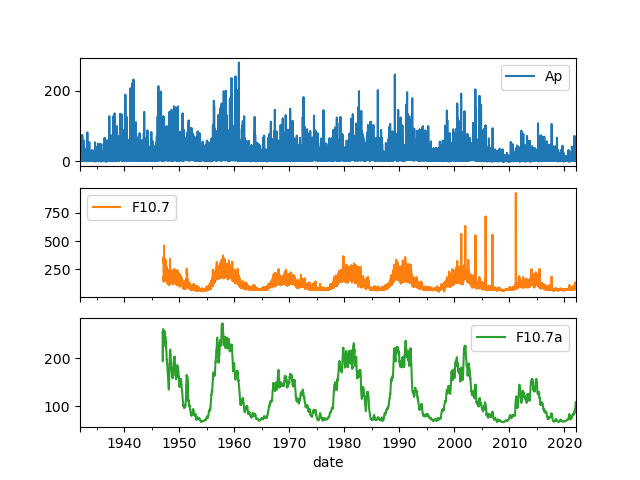

In [14]:
df = pd.read_csv("https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_Ap_SN_F107_since_1932.txt", 
                 delim_whitespace=True,
                 parse_dates={"date": ["year", "month", "day"]},
                 na_values=["-1", "-1.0", "-1.000"],
                 skiprows=40,
                 header=None,
                 index_col="date",
                 usecols=[0, 1, 2, 23, 26],
                 names=["year", "month", "day", "Ap", "F10.7"])
# There are some anomalous 0s in F10.7 as well, so get rid of them too
df.loc[df["F10.7"] < 1, "F10.7"] = np.nan

df["F10.7a"] = df["F10.7"].rolling(81, center=True, min_periods=1).mean()

df.plot(subplots=True);

In [15]:
def get_f107_data(date):
    """Get the f107 and ap data closest to the given date"""
    closest_index = np.argmin(np.abs(df.index - date))
    F107 = df["F10.7"][closest_index]
    F107a = df["F10.7a"][closest_index]
    Ap = df["Ap"][closest_index]
    return (F107, F107a, Ap)

# Get data for the Halloween storm 2003-10-30 12:00
get_f107_data(np.datetime64("2003-10-30T12:00"))

(267.6, 144.558024691358, 191.0)